# Fachprojekt Machine Learning
**Authors:** Anastasiia Korzhylova, Ivan Shishkin, Ramneek Agnihotri, Rodi Mehi

**Due date:** Wednesday, 3. July 2024

## Import necessary components

In [1]:
# Import the necessary libraries
import time, warnings, random, numpy as np
import torch, torch.nn.functional as F
from tabulate import tabulate
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Import the VAE model and functions
import networks
from datasets import create_datasets
from evaluation import evaluate
from interpolation import interpolate
from sampling import plot_reconstruction
from plotting import plot_loss_lr, plot_loss_components

## Set hyperparameters, loss function and optimizing tools

In [2]:
# Hyperparameters
batch_size = 128 # Number of images per update of the network
num_epochs = 10 # One epoch means seeing every image of the training dataset
latent_dim = 256  # Size of the latent space
input_channels = 3  # CIFAR-10 images have 3 color channels
learning_rate = 2e-5 # Determines how drastically the parameters of the network change
output_frequency = 150 # Determines how often the training progress will be logged (in batches)
number_embedding_vectors = 512
embedding_dimension = 128
beta = 0.1

# Select the device that will be used for training: GPU, if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print('=========================================')

# Put the neural network on the selected device
model = networks.VQVAE(input_channels=input_channels, emb_dim=embedding_dimension, n_embed=number_embedding_vectors, beta=beta)
model.to(device)

# Loss function
def loss_function(recon_x, x, vq_loss):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    return recon_loss + vq_loss, recon_loss, vq_loss

# Optimizer selection
optimizer_option = 'adam'

optimizer = None
if optimizer_option == "adam":
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
elif optimizer_option == "adamw":
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
elif optimizer_option == "rmsprop":
  optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
else:
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Learning rate scheduler parameters
lr_schedule_option = 'exponential'

scheduler = None
if lr_schedule_option == 'step':
  scheduler = StepLR(optimizer, step_size=30, gamma=0.5)
elif lr_schedule_option == 'exponential':
  scheduler = ExponentialLR(optimizer, gamma=0.9)
elif lr_schedule_option == 'cosine':
  scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)

# Scaler for AMP
scaler = torch.cuda.amp.GradScaler()

Using device: cuda


## Choose a dataset for training

In [3]:
# Create and visualize the datasets for MNIST / CIFAR10
dataset_name = 'CELEBA'
train_loader, test_loader = create_datasets(dataset_name, batch_size)

Files already downloaded and verified
Files already downloaded and verified


## Training loop

-----------------------------------------------------------------------------------------------------------------------------
Epoch:  1/ 10  Batch:    1  Total Loss:  226525  VQ Loss:  0.842143  Recon Loss:  226524  Commitment Loss:  0.765585  Embedding Loss:  0.765585  LR:  2e-05
Epoch:  1/ 10  Batch:  151  Total Loss:  19960.3  VQ Loss:  1.88778  Recon Loss:  19958.4  Commitment Loss:  1.71616  Embedding Loss:  1.71616  LR:  2e-05
Epoch:  1/ 10  Batch:  301  Total Loss:  12426.8  VQ Loss:  1.90135  Recon Loss:  12424.9  Commitment Loss:  1.7285  Embedding Loss:  1.7285  LR:  2e-05
Epoch:  1/ 10  Batch:  451  Total Loss:  9442.81  VQ Loss:  1.93315  Recon Loss:  9440.87  Commitment Loss:  1.75741  Embedding Loss:  1.75741  LR:  2e-05
Epoch:  1/ 10  Batch:  601  Total Loss:  8555.76  VQ Loss:  1.96497  Recon Loss:  8553.8  Commitment Loss:  1.78634  Embedding Loss:  1.78634  LR:  2e-05
Epoch:  1/ 10  Batch:  751  Total Loss:  7307.9  VQ Loss:  1.96439  Recon Loss:  7305.94  Commitment 

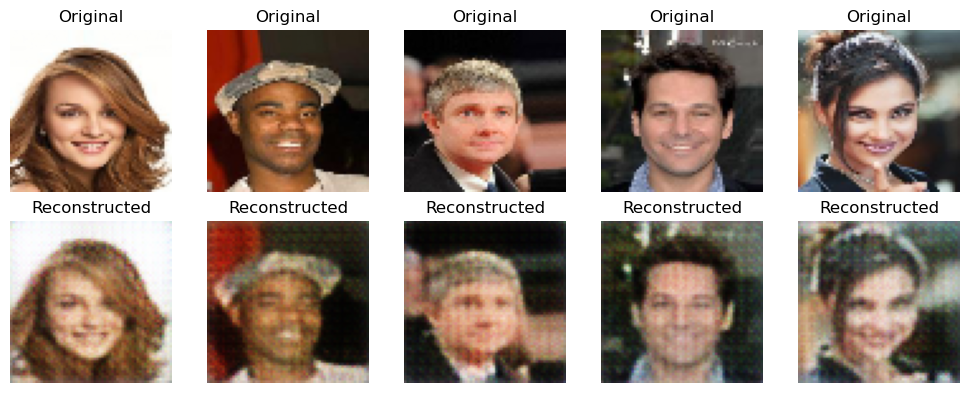

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  2/ 10  Batch:    1  Total Loss:  6134.26  VQ Loss:  1.96718  Recon Loss:  6132.29  Commitment Loss:  1.78835  Embedding Loss:  1.78835  LR:  1.8e-05
Epoch:  2/ 10  Batch:  151  Total Loss:  5845.57  VQ Loss:  1.96736  Recon Loss:  5843.6  Commitment Loss:  1.78851  Embedding Loss:  1.78851  LR:  1.8e-05
Epoch:  2/ 10  Batch:  301  Total Loss:  4627.17  VQ Loss:  1.93108  Recon Loss:  4625.24  Commitment Loss:  1.75552  Embedding Loss:  1.75552  LR:  1.8e-05
Epoch:  2/ 10  Batch:  451  Total Loss:  4843.98  VQ Loss:  1.88843  Recon Loss:  4842.09  Commitment Loss:  1.71675  Embedding Loss:  1.71675  LR:  1.8e-05
Epoch:  2/ 10  Batch:  601  Total Loss:  4660.03  VQ Loss:  1.91368  Recon Loss:  4658.12  Commitment Loss:  1.73971  Emb

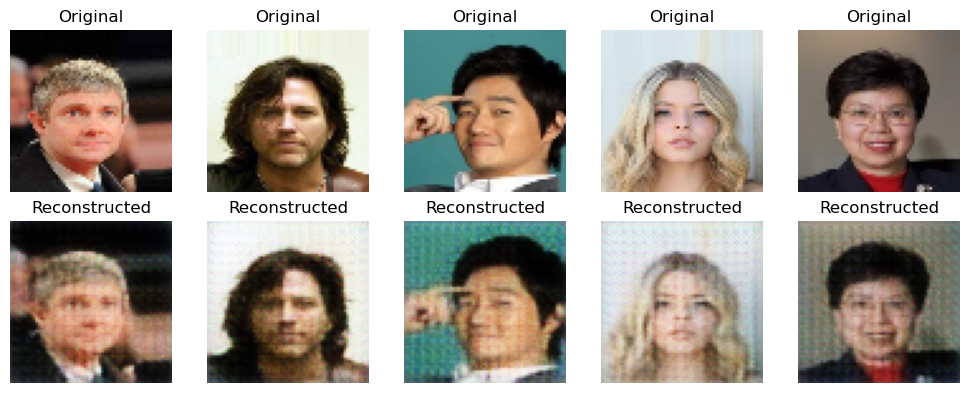

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  3/ 10  Batch:    1  Total Loss:  3375.68  VQ Loss:  1.75897  Recon Loss:  3373.93  Commitment Loss:  1.59906  Embedding Loss:  1.59906  LR:  1.62e-05
Epoch:  3/ 10  Batch:  151  Total Loss:  3341.39  VQ Loss:  1.85515  Recon Loss:  3339.54  Commitment Loss:  1.6865  Embedding Loss:  1.6865  LR:  1.62e-05
Epoch:  3/ 10  Batch:  301  Total Loss:  3334.13  VQ Loss:  1.78105  Recon Loss:  3332.35  Commitment Loss:  1.61914  Embedding Loss:  1.61914  LR:  1.62e-05
Epoch:  3/ 10  Batch:  451  Total Loss:  2946.6  VQ Loss:  1.73512  Recon Loss:  2944.87  Commitment Loss:  1.57738  Embedding Loss:  1.57738  LR:  1.62e-05
Epoch:  3/ 10  Batch:  601  Total Loss:  3231.67  VQ Loss:  1.69417  Recon Loss:  3229.98  Commitment Loss:  1.54016  E

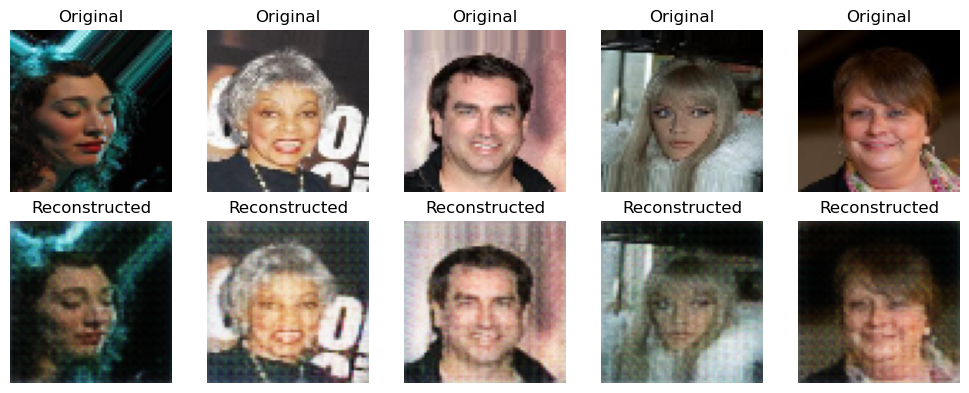

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  4/ 10  Batch:    1  Total Loss:  2777.42  VQ Loss:  1.7048  Recon Loss:  2775.72  Commitment Loss:  1.54982  Embedding Loss:  1.54982  LR:  1.458e-05
Epoch:  4/ 10  Batch:  151  Total Loss:  2454.89  VQ Loss:  1.64589  Recon Loss:  2453.24  Commitment Loss:  1.49626  Embedding Loss:  1.49626  LR:  1.458e-05
Epoch:  4/ 10  Batch:  301  Total Loss:  2328.31  VQ Loss:  1.64382  Recon Loss:  2326.66  Commitment Loss:  1.49438  Embedding Loss:  1.49438  LR:  1.458e-05
Epoch:  4/ 10  Batch:  451  Total Loss:  2466.31  VQ Loss:  1.66944  Recon Loss:  2464.65  Commitment Loss:  1.51767  Embedding Loss:  1.51767  LR:  1.458e-05
Epoch:  4/ 10  Batch:  601  Total Loss:  2364.78  VQ Loss:  1.60245  Recon Loss:  2363.18  Commitment Loss:  1.45

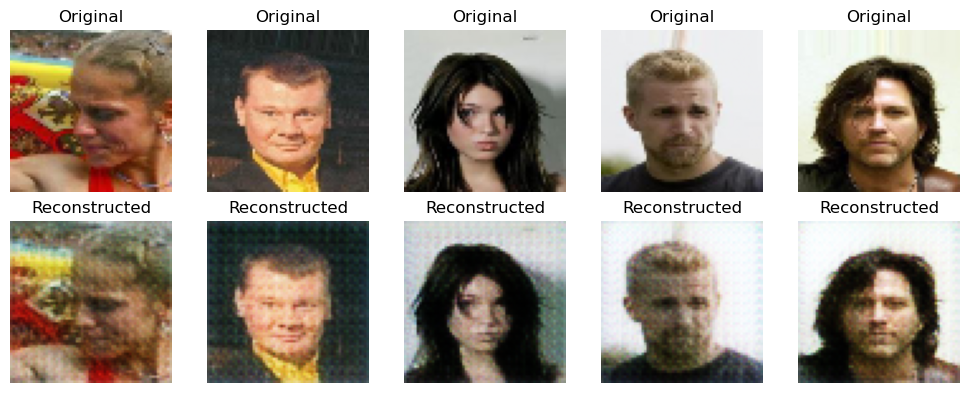

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  5/ 10  Batch:    1  Total Loss:  2114.8  VQ Loss:  1.54388  Recon Loss:  2113.25  Commitment Loss:  1.40352  Embedding Loss:  1.40352  LR:  1.3122e-05
Epoch:  5/ 10  Batch:  151  Total Loss:  1981.61  VQ Loss:  1.53066  Recon Loss:  1980.08  Commitment Loss:  1.39151  Embedding Loss:  1.39151  LR:  1.3122e-05
Epoch:  5/ 10  Batch:  301  Total Loss:  2035.39  VQ Loss:  1.55106  Recon Loss:  2033.83  Commitment Loss:  1.41006  Embedding Loss:  1.41006  LR:  1.3122e-05
Epoch:  5/ 10  Batch:  451  Total Loss:  2063.43  VQ Loss:  1.5299  Recon Loss:  2061.9  Commitment Loss:  1.39082  Embedding Loss:  1.39082  LR:  1.3122e-05
Epoch:  5/ 10  Batch:  601  Total Loss:  1904.32  VQ Loss:  1.46933  Recon Loss:  1902.85  Commitment Loss:  1.

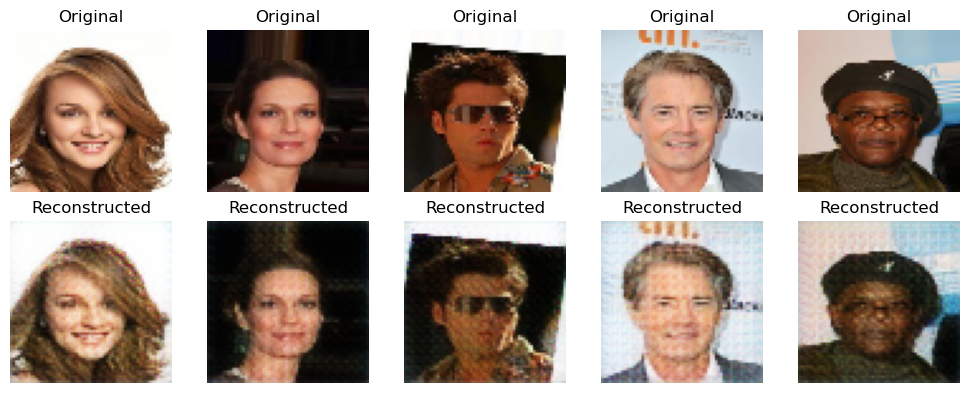

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  6/ 10  Batch:    1  Total Loss:  1852.93  VQ Loss:  1.518  Recon Loss:  1851.41  Commitment Loss:  1.38  Embedding Loss:  1.38  LR:  1.18098e-05
Epoch:  6/ 10  Batch:  151  Total Loss:  1648.71  VQ Loss:  1.47009  Recon Loss:  1647.24  Commitment Loss:  1.33645  Embedding Loss:  1.33645  LR:  1.18098e-05
Epoch:  6/ 10  Batch:  301  Total Loss:  1853.6  VQ Loss:  1.46043  Recon Loss:  1852.14  Commitment Loss:  1.32766  Embedding Loss:  1.32766  LR:  1.18098e-05
Epoch:  6/ 10  Batch:  451  Total Loss:  1688.25  VQ Loss:  1.48481  Recon Loss:  1686.77  Commitment Loss:  1.34983  Embedding Loss:  1.34983  LR:  1.18098e-05
Epoch:  6/ 10  Batch:  601  Total Loss:  1699.95  VQ Loss:  1.47026  Recon Loss:  1698.48  Commitment Loss:  1.33

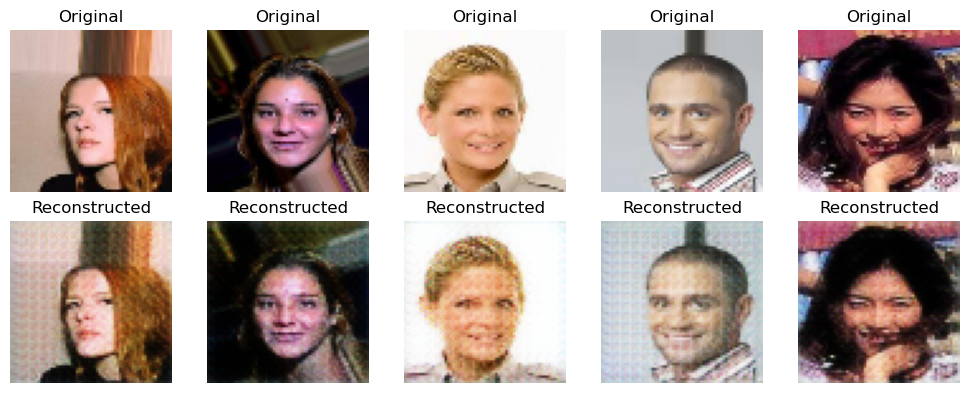

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  7/ 10  Batch:    1  Total Loss:  1433.88  VQ Loss:  1.44285  Recon Loss:  1432.44  Commitment Loss:  1.31168  Embedding Loss:  1.31168  LR:  1.06288e-05
Epoch:  7/ 10  Batch:  151  Total Loss:  1620.95  VQ Loss:  1.4582  Recon Loss:  1619.49  Commitment Loss:  1.32563  Embedding Loss:  1.32563  LR:  1.06288e-05
Epoch:  7/ 10  Batch:  301  Total Loss:  1768.93  VQ Loss:  1.48895  Recon Loss:  1767.44  Commitment Loss:  1.35359  Embedding Loss:  1.35359  LR:  1.06288e-05
Epoch:  7/ 10  Batch:  451  Total Loss:  1507.99  VQ Loss:  1.45596  Recon Loss:  1506.54  Commitment Loss:  1.3236  Embedding Loss:  1.3236  LR:  1.06288e-05
Epoch:  7/ 10  Batch:  601  Total Loss:  1534.9  VQ Loss:  1.42351  Recon Loss:  1533.48  Commitment Loss: 

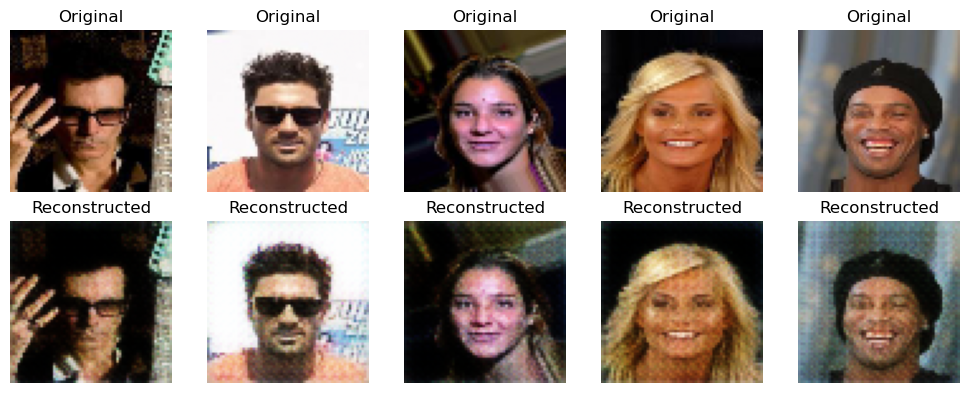

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  8/ 10  Batch:    1  Total Loss:  1340.22  VQ Loss:  1.42866  Recon Loss:  1338.79  Commitment Loss:  1.29878  Embedding Loss:  1.29878  LR:  9.56594e-06
Epoch:  8/ 10  Batch:  151  Total Loss:  1325.26  VQ Loss:  1.4477  Recon Loss:  1323.81  Commitment Loss:  1.31609  Embedding Loss:  1.31609  LR:  9.56594e-06
Epoch:  8/ 10  Batch:  301  Total Loss:  1340.56  VQ Loss:  1.4244  Recon Loss:  1339.14  Commitment Loss:  1.2949  Embedding Loss:  1.2949  LR:  9.56594e-06
Epoch:  8/ 10  Batch:  451  Total Loss:  1248.96  VQ Loss:  1.39728  Recon Loss:  1247.56  Commitment Loss:  1.27025  Embedding Loss:  1.27025  LR:  9.56594e-06
Epoch:  8/ 10  Batch:  601  Total Loss:  1373.13  VQ Loss:  1.39261  Recon Loss:  1371.74  Commitment Loss: 

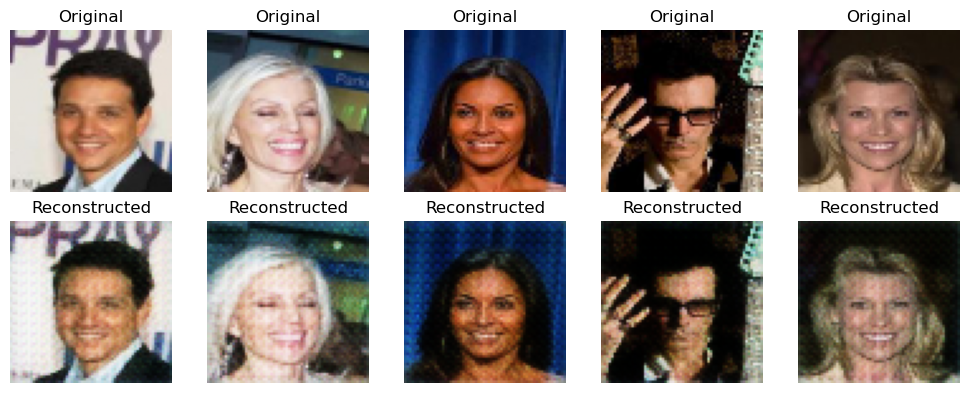

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  9/ 10  Batch:    1  Total Loss:  1209.44  VQ Loss:  1.42169  Recon Loss:  1208.02  Commitment Loss:  1.29245  Embedding Loss:  1.29245  LR:  8.60934e-06
Epoch:  9/ 10  Batch:  151  Total Loss:  1177.27  VQ Loss:  1.44159  Recon Loss:  1175.83  Commitment Loss:  1.31054  Embedding Loss:  1.31054  LR:  8.60934e-06
Epoch:  9/ 10  Batch:  301  Total Loss:  1203.92  VQ Loss:  1.42072  Recon Loss:  1202.5  Commitment Loss:  1.29156  Embedding Loss:  1.29156  LR:  8.60934e-06
Epoch:  9/ 10  Batch:  451  Total Loss:  1228.44  VQ Loss:  1.41781  Recon Loss:  1227.02  Commitment Loss:  1.28892  Embedding Loss:  1.28892  LR:  8.60934e-06
Epoch:  9/ 10  Batch:  601  Total Loss:  1309.74  VQ Loss:  1.4012  Recon Loss:  1308.34  Commitment Loss

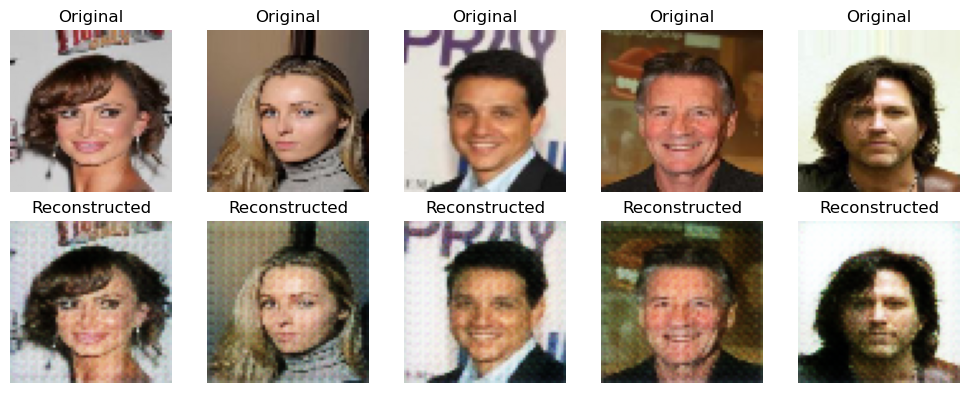

-----------------------------------------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------------------
Epoch:  10/ 10  Batch:    1  Total Loss:  1125.76  VQ Loss:  1.40093  Recon Loss:  1124.36  Commitment Loss:  1.27357  Embedding Loss:  1.27357  LR:  7.74841e-06
Epoch:  10/ 10  Batch:  151  Total Loss:  1078.28  VQ Loss:  1.39597  Recon Loss:  1076.88  Commitment Loss:  1.26906  Embedding Loss:  1.26906  LR:  7.74841e-06
Epoch:  10/ 10  Batch:  301  Total Loss:  1021.91  VQ Loss:  1.39764  Recon Loss:  1020.51  Commitment Loss:  1.27058  Embedding Loss:  1.27058  LR:  7.74841e-06
Epoch:  10/ 10  Batch:  451  Total Loss:  1188.69  VQ Loss:  1.42567  Recon Loss:  1187.27  Commitment Loss:  1.29606  Embedding Loss:  1.29606  LR:  7.74841e-06
Epoch:  10/ 10  Batch:  601  Total Loss:  1047.31  VQ Loss:  1.44136  Recon Loss:  1045.87  Commitme

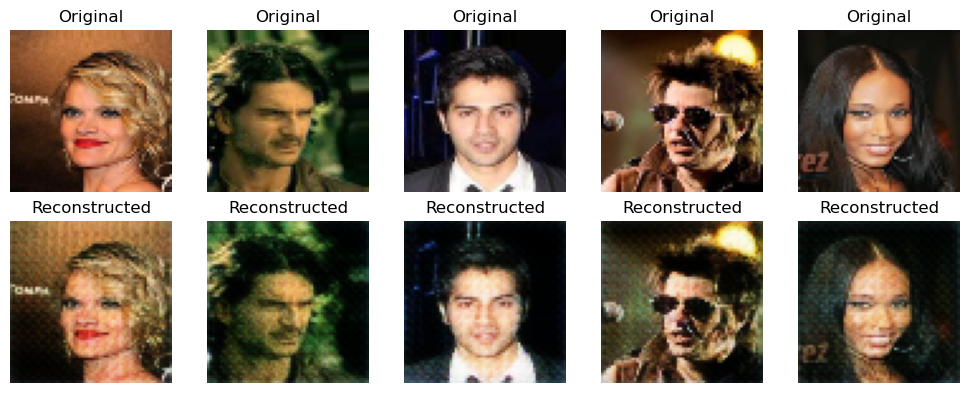

-----------------------------------------------------------------------------------------------------------------------------


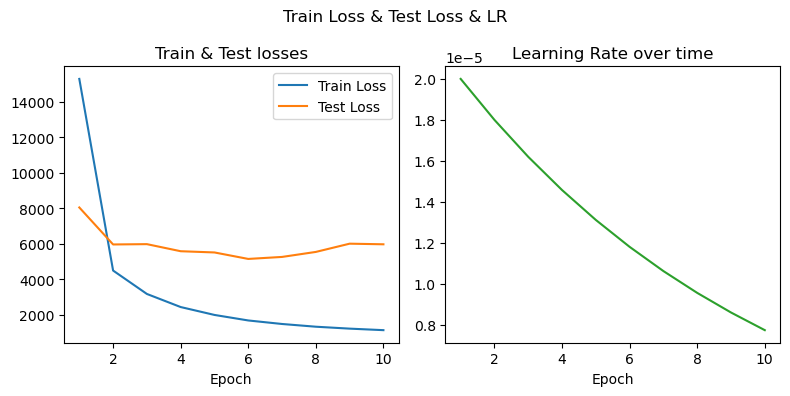

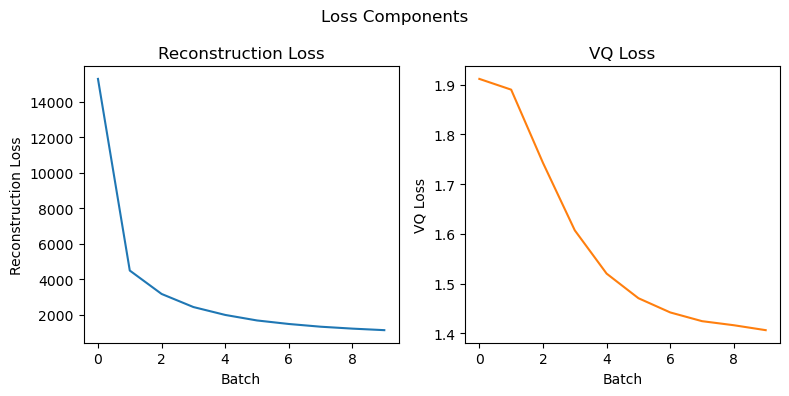

In [4]:
# Suppress user warnings
warnings.filterwarnings("ignore")

# Initialize lists for tracking losses and learning rates
train_losses = []
test_losses = []
learning_rates = []
reconstruction_losses = []
vq_losses = []
commitment_losses = []
embedding_losses = []

# Training loop
for epoch in range(num_epochs):
    print('-----------------------------------------------------------------------------------------------------------------------------')
    model.train()

    batch_recon_losses = []
    batch_vq_losses = []
    batch_total_losses = []

    epoch_start_time = time.time()  # Start of time measurement

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            # Forward pass
            recon_batch, vqloss, embedding_loss, commitment_loss = model(data)

            # Compute loss
            loss, recon_loss, _  = loss_function(recon_batch, data, vqloss)

        # Backward pass
        scaler.scale(loss).backward()

        scaler.step(optimizer)
        scaler.update()

        # Save the loss values for the current batch
        curr_loss = loss.detach().item()
        curr_vqloss = vqloss.detach().item()
        curr_recon_loss = recon_loss.detach().item()
        curr_commitment_loss = commitment_loss.detach().item()
        curr_embedding_loss = embedding_loss.detach().item()
        batch_total_losses.append(curr_loss)
        batch_vq_losses.append(curr_vqloss)
        batch_recon_losses.append(curr_recon_loss)

        # Log training loss and current learning rate
        if batch_idx % output_frequency == 0:
            log = [['Epoch:', f'{epoch + 1:3d}/{num_epochs:3d}', 'Batch:', f'{batch_idx + 1:3d}',
                    'Total Loss:', f'{curr_loss:.6f}', 'VQ Loss:', f'{curr_vqloss:.6f}',
                    'Recon Loss:', f'{curr_recon_loss:.6f}',
                    'Commitment Loss:', f'{curr_commitment_loss:.6f}',
                    'Embedding Loss:', f'{curr_embedding_loss:.6f}',
                    'LR:', scheduler.get_last_lr()[0]]]
            print(tabulate(log, tablefmt="plain"))

    # Step the learning rate scheduler
    if scheduler is not None:
        lr = scheduler.get_last_lr()[0]
        scheduler.step()
    else:
        lr = learning_rate
    learning_rates.append(lr)

    # After the epoch, evaluate the accuracy on the test dataset
    mean_loss = evaluate(model, test_loader, loss_function, device)
    test_losses.append(mean_loss)

    # Save the average loss values
    average_total_loss = torch.tensor(batch_total_losses).mean().item()
    average_recon_loss = torch.tensor(batch_recon_losses).mean().item()
    average_vq_loss = torch.tensor(batch_vq_losses).mean().item()

    train_losses.append(average_total_loss)
    reconstruction_losses.append(average_recon_loss)
    vq_losses.append(average_vq_loss)

    # End of time measurement
    elapsed_time = time.time() - epoch_start_time

    # Log epoch results
    headers = ["Epoch", "Mean Test Loss", "Time"]
    data = [[epoch + 1, f"{mean_loss:.4f}", f"{elapsed_time:.2f}s"]]
    print(tabulate(data, headers=headers, tablefmt="fancy_grid"))

    # Generate reconstructed test images after each epoch
    plot_reconstruction(model, test_loader, device, num_samples=5)
    print('-----------------------------------------------------------------------------------------------------------------------------')

# Plot Train Loss & Test Loss & LR
plot_loss_lr(num_epochs, train_losses, test_losses, learning_rates)

# Plot each loss component
plot_loss_components(reconstruction_losses, vq_losses)


## Sample some images

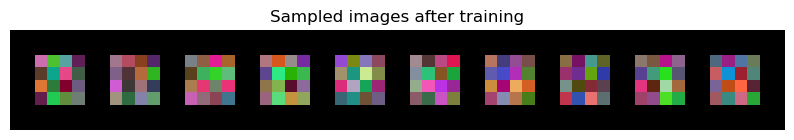

In [5]:
# Sample some VQ-VAE-generated images
vqvae = networks.VQVAE(input_channels=input_channels, emb_dim=embedding_dimension, n_embed=number_embedding_vectors, beta=beta).to(device)
samples = vqvae.sample(10)
grid = make_grid(samples.cpu(), nrow=10, normalize=True)  # Move the tensor to CPU
np_img = grid.numpy()
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(np_img, (1, 2, 0)))
plt.title(f'Sampled images after training')
plt.axis('off')
plt.show()

## Vector interpolation

In [6]:
# Create a video  of images that show the interpolation on a linear trajectory between z1 and z2
images, _ = next(iter(test_loader))
z1 = model.vectorquantizer(model.encoder(random.choice(images).to(device).unsqueeze(0)))[0]
z2 = model.vectorquantizer(model.encoder(random.choice(images).to(device).unsqueeze(0)))[0]
interpolate(z1, z2, model, steps=200, file_format='gif')

Interpolation GIF saved as output/interpolation.gif.
